# Implementing **Pytorch** CNN Model Classifier on the MNIST Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimenstions (# of images, height, width, # of channels)

transform = transforms.ToTensor()

In [3]:
# Train data
train_data = datasets.MNIST(root='data/', train=True, download=True, transform=transform)

In [4]:
# Test data
test_data = datasets.MNIST(root='data/', train=False, download=True, transform=transform)

In [5]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [6]:
# Let's create a small batch size for images...let's say 10 for each batch
train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=10)

In [7]:
# Define CNN Model for fun without OOP

conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)

In [8]:
# Grab 1 MNIST record/image/sample
for i, (X_train, y_train) in enumerate(train_data):
    break

X_train.shape

torch.Size([1, 28, 28])

In [9]:
x = X_train.view(1, 1, 28, 28)

In [10]:
# Pass thru the first conv layer
x = F.relu(conv1(x))
x.shape  # remember the kernel size of conv1 is (3, 3) and theinput size = (28, 28) --> (28 - 3)/1 + 1 = 26 -> (26 * 26)

torch.Size([1, 6, 26, 26])

In [11]:
x = F.max_pool2d(input=x, kernel_size=2, stride=2) # 26 / 2 = 13

In [12]:
x.shape

torch.Size([1, 6, 13, 13])

In [13]:
# Pass thru the second conv layer
x = F.relu(conv2(x))

In [14]:
x.shape  # (13 - 3)/1 + 1 = 11, also there are 16 kernels, so the output has 16 channels

torch.Size([1, 16, 11, 11])

In [15]:
# Another pooling layer
x = F.max_pool2d(input=x, kernel_size=2, stride=2)

In [16]:
x.shape  # 11 / 2 = 5.5 but we can't invert data, so we round down the size

torch.Size([1, 16, 5, 5])

### Explanation of Size Reduction from (1, 28, 28) to (16, 5, 5):
# $$
    \frac{(\frac{(\frac{(\frac{(28 - 3)}{1} + 1)}{2}) - 3}{1} + 1)}{2} = 5.5 \sim \lfloor 5.5 \rfloor = 5
$$

## Building the CNN Model

In [17]:
# Much better structured way for building a Pytorch Model
# Class Model
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        
        # after conv2 the shape will become (16, 5, 5) -> so the FC layer should have 16 * 5 * 5 neurons
        self.fc1 = nn.Linear(in_features=5 * 5 * 16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=10)

    def forward(self, X):
        # First pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=2)  # default stride is kernel_size which here is 2.

        # Second conv block
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)

        # Re-View to flatten it out
        X = X.view(-1, (16 * 5 * 5))  # -1 because of variying batch sizes

        # Fully Connected Layers

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.out(X)

        return F.log_softmax(X, dim=1)
        

In [18]:
# Create an Instance of our Model
torch.manual_seed(42)

In [19]:
model = CNN_Model()
model

CNN_Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:
# Define Loss function and Optimizer

# Loss function:
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

### Training the CNN Model

In [21]:
# # Keep it commented, unless you want to retrain the CNN model

# import time

# tik = time.time()  # start timing the model training process

# # Create variables to track things
# epochs = 5
# train_losses = []
# test_losses = []
# num_train_correct = []
# num_test_correct = []

# # For Loop of epochs
# for epoch in range(epochs):
#     trn_corr = 0
#     tst_corr =0
    

#     # Train
#     for batch_num, (X_train, y_train) in enumerate(train_loader):
#         batch_num += 1  # start our batches at 1, each batch contains 10 images

#         y_pred = model(X_train)  # or: model.forward(X_train), y_pred is not flattend
#         loss = criterion(y_pred, y_train)  # how off are we? compare the predictions to the correct answers in y_train

#         predicted_digit = torch.max(y_pred.data, 1)[1]  # add up the number of correct predictions.
#         num_batch_corr = (predicted_digit == y_train).sum()  # how many we got correct from this batch.
#         trn_corr += num_batch_corr

#         # Update parameters
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
         

#     # Print out some results
#         if batch_num % 600 == 0:
#             print(f'Epoch: {epoch:4},  Batch: {batch_num:6}, loss:{loss.item():.6f}')

#     train_losses.append(loss)
#     num_train_correct.append(trn_corr)



#     # Test
#     with torch.no_grad():  # We don't want to update weights and biases with test set
        
#         for batch_num, (X_test, y_test) in enumerate(test_loader):
#             y_pred = model(X_test)

#             predicted_digit = torch.max(y_pred.data, 1)[1]  # Adding up correct predictions
#             tst_corr += (predicted_digit == y_test).sum()


#         loss = criterion(y_pred, y_test)
#         test_losses.append(loss)
#         num_test_correct.append(tst_corr)


# tok = time.time()  # end timing the model training process

# total_time = tok - tik
# print(f"Total Training Time: {total_time / 60:6.4f} minutes!!!")

#### Save the CNN Model and It's Metrics

In [22]:
# data_to_save = {
#     'model_state_dict': model.state_dict(),
#     'train_losses': train_losses,
#     'test_losses': test_losses,
#     'num_train_correct': num_train_correct,
#     'num_test_correct': num_test_correct
# }

# torch.save(data_to_save, 'CNN_Model_and_Metrics_MNIST.pt')

### Load the CNN Model and It's Metrics

In [23]:
loaded_data = torch.load('CNN_Model_and_Metrics_MNIST.pt', weights_only=True)
print(loaded_data.keys())

model_state_dict, train_losses, test_losses, num_train_correct, num_test_correct = (
    loaded_data['model_state_dict'],
    loaded_data['train_losses'],
    loaded_data['test_losses'],
    loaded_data['num_train_correct'],
    loaded_data['num_test_correct']
)

model.load_state_dict(model_state_dict)

dict_keys(['model_state_dict', 'train_losses', 'test_losses', 'num_train_correct', 'num_test_correct'])


<All keys matched successfully>

### Graph the CNN Model Evaluation

[0.07828047126531601, 0.14917543530464172, 0.009517979808151722, 0.0049559809267520905, 0.011776838451623917]

[tensor(0.0783, requires_grad=True), tensor(0.1492, requires_grad=True), tensor(0.0095, requires_grad=True), tensor(0.0050, requires_grad=True), tensor(0.0118, requires_grad=True)]


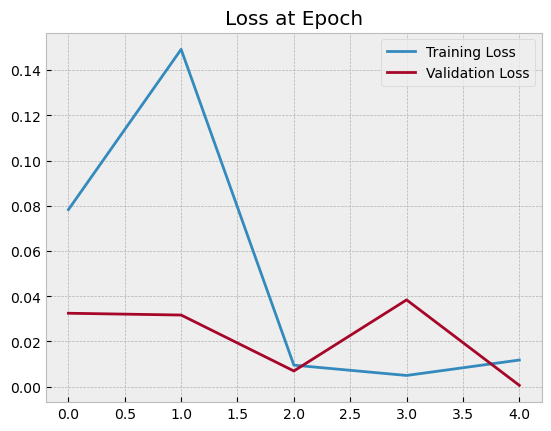

In [24]:
# Plot Training Loss over Epochs

# Convert train_losses as a list of tensors to list of loss items
train_losses_list = [t_loss.item() for t_loss in train_losses]
print(train_losses_list, train_losses, sep='\n\n')

plt.plot(train_losses_list, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')

plt.title("Loss at Epoch")
plt.legend();
## Note: very strange loss you can ever see, validation loss was almost 0 at the beginning.

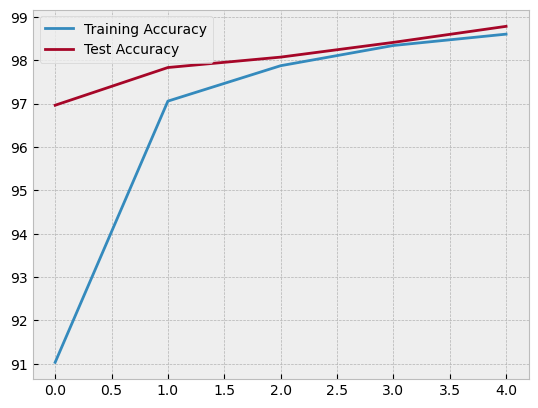

In [25]:
# Plot Models Accuracy at Training and Test sets

plt.plot([t / 600 for t in num_train_correct], label='Training Accuracy')
plt.plot([t / 100 for t in num_test_correct], label='Test Accuracy')

plt.legend()

In [26]:
# Validation on Test Set

test_load_whole = DataLoader(test_data, batch_size=10000,
                             shuffle=False)

with torch.no_grad():
    test_accuracy = 0.
    
    for X_test, y_test in test_load_whole:
        y_pred = model(X_test).max(1)[1]
        test_accuracy += (y_pred == y_test).sum()
        test_accuracy /= 100
        print(test_accuracy)

tensor(98.7800)


## Test Model on a New Image

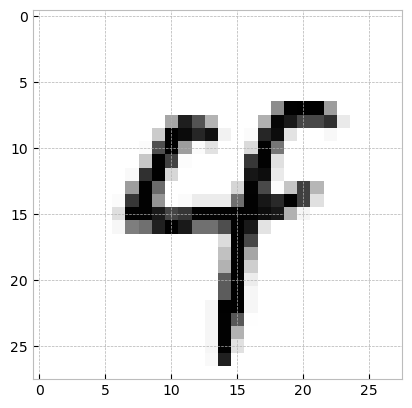

In [27]:
# A single image of MNIST dataset
plt.imshow(test_data[4001][0].reshape(28, 28), cmap='Greys')

In [28]:
# Let model predict the digit
# Always use torch.no_grad() for inference and making predictions, becuase it doesn't lead to increased memory usage and slower performace when using without it

with torch.no_grad():
    print(f'1st Approach:  Predicted digit: {model(test_data[4001][0]).max(1)[1].item()}, True Label: {test_data[4001][1]}')
## .max(1)[1]: calculates maximum along each row (column based) and then it gives us the value of the maximum prediction and it's index in a tuple,
## [1] is used to select the second value of the tuple which is the index of the maximum log-probability which indicated the digit it has predicted.

## the other approach is using .argmax() instead of max()[1], but it doens't provide log-probability anymore.
    print(f'2nd Approach:  Predicted digit: {model(test_data[4001][0]).argmax(1).item()}, True Label: {test_data[4001][1]}')

1st Approach:  Predicted digit: 4, True Label: 4
2nd Approach:  Predicted digit: 4, True Label: 4
